<a href="https://colab.research.google.com/github/ICBI/AIMAHEAD_GU/blob/main/Courses/ML_Concepts_in_R/Module_01_Introduction_to_Classification/R_Version_Module_01_Introduction_to_Classification_speedup_with_libraryDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/AAlogo1.jpg" alt="Powered by" width="150"/>

#AI/ML for Healthcare Applications : Lab 1 Introduction to Classification (R notebook)

Based on material from the Georgetown [Health Informatics and Data Science](https://healthinformatics.georgetown.edu) program and licensed under  [CC4.0](https://creativecommons.org/licenses/by/4.0/)

---

#Module 1: Introduction to Classification

The aim of this notebook is to provide an hands-on demo to machine learning in R. <text removed>




The learning objective of this notebook are:
* Learning how to train a basic classification model
* Use the model to make predictions on new unseen data
* Generate a confusion matrix and a classification report
* Learn how to calculate different metrics
* Plot ROC curves
* Try other classifiers and compare models

## Packages



We will start by setting some variables and installing an R package that will help us organize and visualize the data. Other packages will be installed and loaded as necessary.

In [5]:
#system('sudo apt install libudunits2-dev')
#install.packages("caret")

In [6]:
untar("Module_01_R_library.tar.gz", "library")

In [7]:
.libPaths("library")

This can take a bit of time, since there are a number of dependencies for the caret package. Once they are finished installing, we can proceed to load them into our environment.

In [8]:
#Import packages
library(dplyr)
library(ggplot2)
library(caret)         # for machine learning functions and classification models
# Set default plot size in ggplot2
theme_set(theme_gray(base_size = 14))
options(repr.plot.width = 10, repr.plot.height = 10)

#install.packages("randomForest")
#install.packages("e1071")
#install.packages("pROC")
#install.packages("MLmetrics")
#install.packages("ROCR")

#library(randomForest)   # for Random Forest model
#library(e1071)         # for SVM model
#library(class)         # for KNN model
#library(pROC)          # for ROC curves
#library(MLmetrics)     # for F1 score, precision, recall
#library(ROCR)          # for ROC and AUC plots



## Part 1: Load and Format the Dataset

We will be building and evaluating models to predict **diabetes** using using the diabetes dataset from the National Institute of Diabetes and Digestive and Kidney Diseases (**NIDDK**).

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

We will be using the **NIDDK diabetes dataset**, which contains 768 female patients of at least 21 years old.  Fields in this dataset are:




* **Pregnancies:** Number of times pregnant
* **Glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* **BloodPressure:** Diastolic blood pressure (mm Hg)
* **SkinThickness:** Triceps skin fold thickness (mm)
* **Insulin:** 2-Hour serum insulin (mu U/ml)
* **BMI:** Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction:** Diabetes pedigree function
* **Age:** Age (years)
* **Outcome:** Class variable (0 or 1); class value 1 is interpreted as "tested positive for diabetes"


Let's explore the dataset. You must first obtain the data file "diabetes.csv" and upload it to a directory that is accessable by this colab notebook.

In [9]:
# Set the URL and file path for downloading the file
url <- "https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/ML_Concepts/diabetes.csv"
destfile <- "diabetes.csv"

# Download the CSV file from the URL
download.file(url, destfile)


In [10]:
diabetes_df <- read.csv(destfile)

We can use the head() function to inspect the first few rows of the dataset, and the dim() function confirms that we have 9 columns of data on 768 patients.

In [11]:
head(diabetes_df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,NaN,33.6,0.627,50,1
2,1,85,66,29,NaN,26.6,0.351,31,0
3,8,183,64,NaN,NaN,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,NaN,NaN,25.6,0.201,30,0


In [12]:
dim(diabetes_df)

[1] 768   9

A common problem with large datasets is missing values. We can quantify how many of patients are missing some data by using the "is.na()" and "colSums()" methods to generate a count of missing values, broken down by the fields in our dataset.

In [13]:
missing_values <- colSums(is.na(diabetes_df))
print(missing_values)

             Pregnancies                  Glucose            BloodPressure 
                       0                        5                       35 
           SkinThickness                  Insulin                      BMI 
                     227                      374                       11 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0 


The missing values in the "Pregnancies" field actually correspond to the patient never having given birth. Here, we can replace the missing pregnacy data with a 0 by using the is.na() function.

In [14]:
diabetes_df$Pregnancies[is.na(diabetes_df$Pregnancies)] <- 0

Similarly, we can use the "is.na()" method to replacing the other missing values in the dataset. We can select any value that makes sense for the given field, and in this case we use the median value to replace the missing data from the corresponding column.

In [15]:
diabetes_df$Glucose[is.na(diabetes_df$Glucose)] <- median(diabetes_df$Glucose, na.rm = TRUE)
diabetes_df$BloodPressure[is.na(diabetes_df$BloodPressure)] <- median(diabetes_df$BloodPressure, na.rm = TRUE)
diabetes_df$SkinThickness[is.na(diabetes_df$SkinThickness)] <- median(diabetes_df$SkinThickness, na.rm = TRUE)
diabetes_df$Insulin[is.na(diabetes_df$Insulin)] <- median(diabetes_df$Insulin, na.rm = TRUE)
diabetes_df$BMI[is.na(diabetes_df$BMI)] <- median(diabetes_df$BMI, na.rm = TRUE)

And we can verify that all missing data has been replaced using the "is.na()" and "colSum()" methods in series.

In [16]:
missing_values <- colSums(is.na(diabetes_df))
print(missing_values)

             Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0 


We can see that all the missing values have now been replaced. Using table() on the Outcome column, we can summarize the "Outcome" column of our dataframe after renaming using colnames().

In [17]:
outcome_counts <-  as.data.frame(table(diabetes_df$Outcome))
colnames(outcome_counts) <- c("Outcome", "Count")
print(outcome_counts)

  Outcome Count
1       0   500
2       1   268


We can see that there are 500 patients without a diabetes diagnosis, and 268 who do have diabetes. But before we can train ML models, we have to seperate the features (`X`) and the outcome variable (`y`)

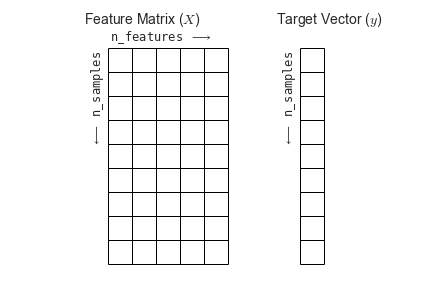

To separate our features from the outcome label, we can use "%in%" to remove the "Outcome" column from the dataframe, and reassign the result to X_df. For the outcome label, we can simply assign the "Outcome" column to a new vector.

In [18]:
X_df <- diabetes_df[, !names(diabetes_df) %in% "Outcome"]
y_df <- diabetes_df$Outcome

Using the dim() and length() methods, we can varify that X_df and y_df are what we expect. The data for all 768 patients has been separated in the 8 feature columns and 1 label column.

In [19]:
X_shape <- dim(X_df)
X_shape

y_shape <- length(y_df)
y_shape

[1] 768   8

[1] 768

We can inspect our feature matrix and vector of labels using head().



In [20]:
head(X_df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,6,148,72,35,125,33.6,0.627,50
2,1,85,66,29,125,26.6,0.351,31
3,8,183,64,29,125,23.3,0.672,32
4,1,89,66,23,94,28.1,0.167,21
5,0,137,40,35,168,43.1,2.288,33
6,5,116,74,29,125,25.6,0.201,30


In [21]:
head(y_df)

[1] 1 0 1 0 1 0

To begin, let's build models on a subset of `X` (say 2 features). This will make visualization easier. We can subset the feature data frame by a list of columns, in this case, "Glucose and "Age".

In [22]:
X_subset_df <- X_df[, c("Glucose", "Age")]

Here we build a simple function to visualize a 2D dataset and color the points by the outcome label. The function takes in 3 variables; the features (X_df), the labels (y), and the plot title (title) which is set to "Data in 2D" by default. The function returns the figure.

In [23]:
# Function to visualize 2D data
visualize_2d <- function(X_df, y, title = "Data in 2D") {
  # Combine X_df and y into a data frame for ggplot2
  plot_data <- cbind(X_df, Outcome = as.factor(y))

  # Create the plot
  fig <- ggplot(plot_data, aes(x = Glucose, y = Age, color = Outcome)) +
    geom_point(size = 3) +
    labs(title = title, x = "x1", y = "x2") +
    theme_minimal(base_size = 14) +
    theme(legend.position = "right")

  # Display the plot
  print(fig)

  # Return the plot object for further use
  return(fig)
}



By setting the feature and label dataframes to our subset of data, we can visualize the relationship between Glucose on the x-axis with age on the y-axis.

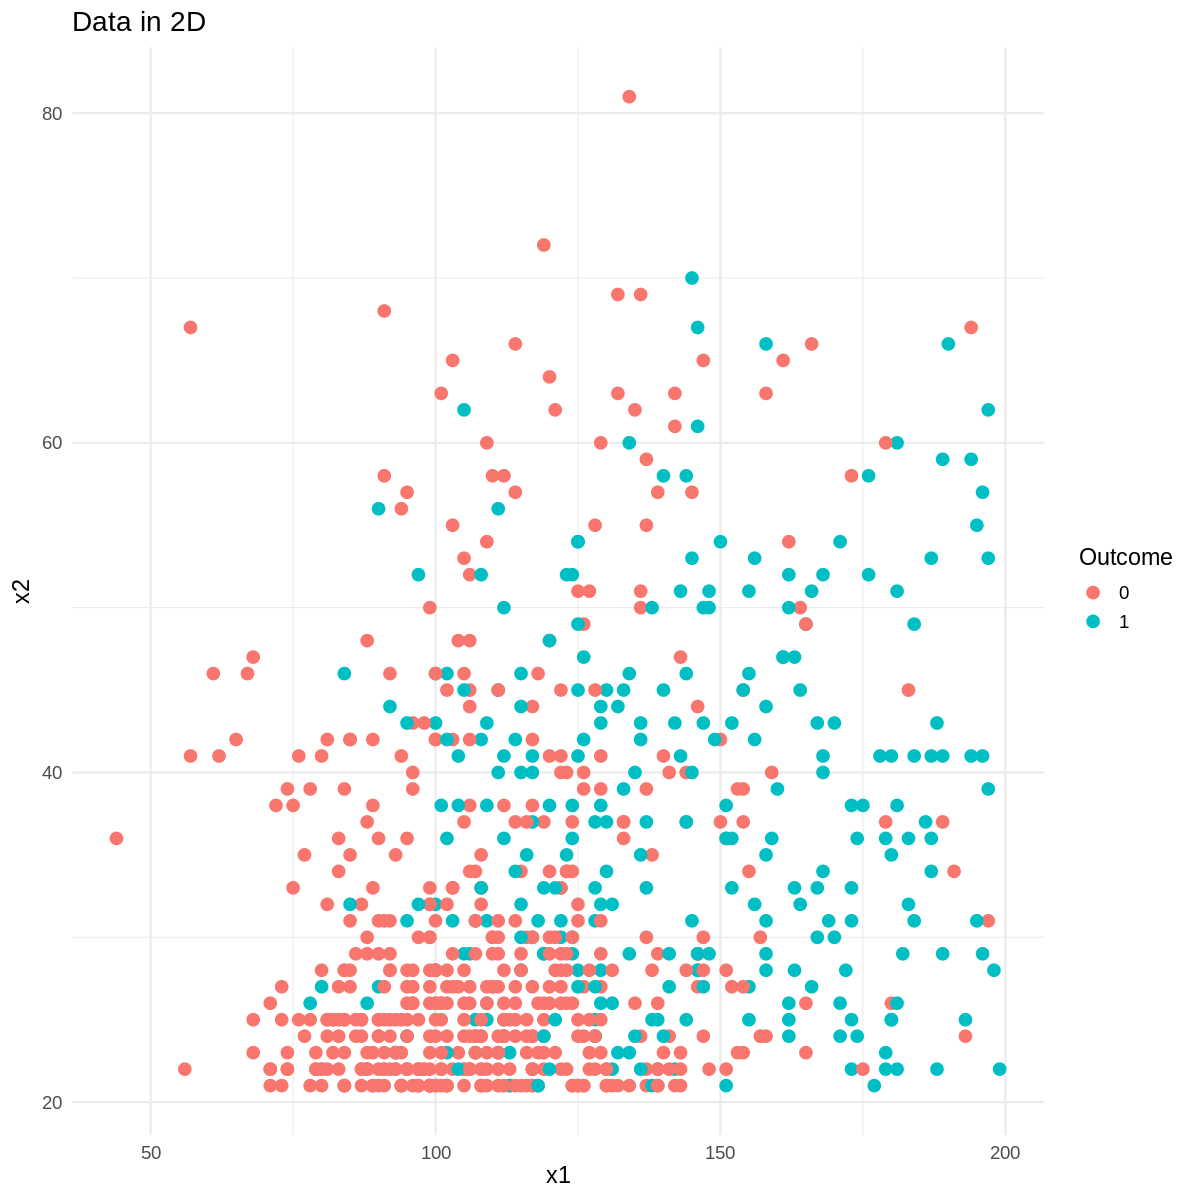

In [24]:
fig <- visualize_2d(X_subset_df, y_df)


There seems to be a relationship between these 2 vairables and diabetes, where it seems more likely that increasing age and glucose levels are associated with diabetes

## Part 2: Logistic Regression

Let's fit a **Logistic Regression** model on this 2d data. Logistic Regression is a basic **classification model** that uses a logistic function to model a binary dependent variable. R has a built in function to generate fit generalized linear models called glm()/ https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm

We define the data frame and which columns we want to use for the dependent and independent variables. In this case, we are using a binomial distribution to model the dependence of the Outcome on the Glucose and Age columns of the "diabetes_df" dataframe.

In [25]:
lr_model <- glm(Outcome ~ Glucose + Age, data = diabetes_df, family = binomial)
summary(lr_model)


Call:
glm(formula = Outcome ~ Glucose + Age, family = binomial, data = diabetes_df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.246837   0.477889 -13.072  < 2e-16 ***
Glucose      0.038362   0.003414  11.238  < 2e-16 ***
Age          0.024194   0.007453   3.246  0.00117 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 993.48  on 767  degrees of freedom
Residual deviance: 783.05  on 765  degrees of freedom
AIC: 789.05

Number of Fisher Scoring iterations: 4


Here, we define a funtion to visualize the decision boundary of the 2-d model by plotting the decision boundary on the same plot as our datapoints.

In [26]:
plot_decision_boundary <- function(model, data) {
  # Create a grid of values for prediction
  xlim <- range(data$Glucose)
  ylim <- range(data$Age)

  # Generate a sequence of values for Glucose and Age
  x_vals <- seq(xlim[1], xlim[2], length.out = 100)
  y_vals <- seq(ylim[1], ylim[2], length.out = 100)

  # Create a grid of points
  grid <- expand.grid(Glucose = x_vals, Age = y_vals)

  # Predict probabilities using the model
  grid$prob <- predict(model, newdata = grid, type = "response")

  # Add the Outcome variable to the original data
  data$Outcome <- as.factor(data$Outcome)  # Ensure Outcome is a factor

  # Create the base plot
  fig <- ggplot(data, aes(x = Glucose, y = Age, color = Outcome)) +
    geom_point(size = 2, alpha = 0.7) +
    geom_contour(data = grid, aes(z = prob), breaks = 0.5, color = "black", linewidth = 1) +  # Use linewidth instead of size
    labs(title = "Decision Boundary", x = "Glucose", y = "Age") +
    theme_minimal(base_size = 14)

  # Return the plot object
  return(fig)
}


Now we can plot the dicision boundary of our 2D regression model.

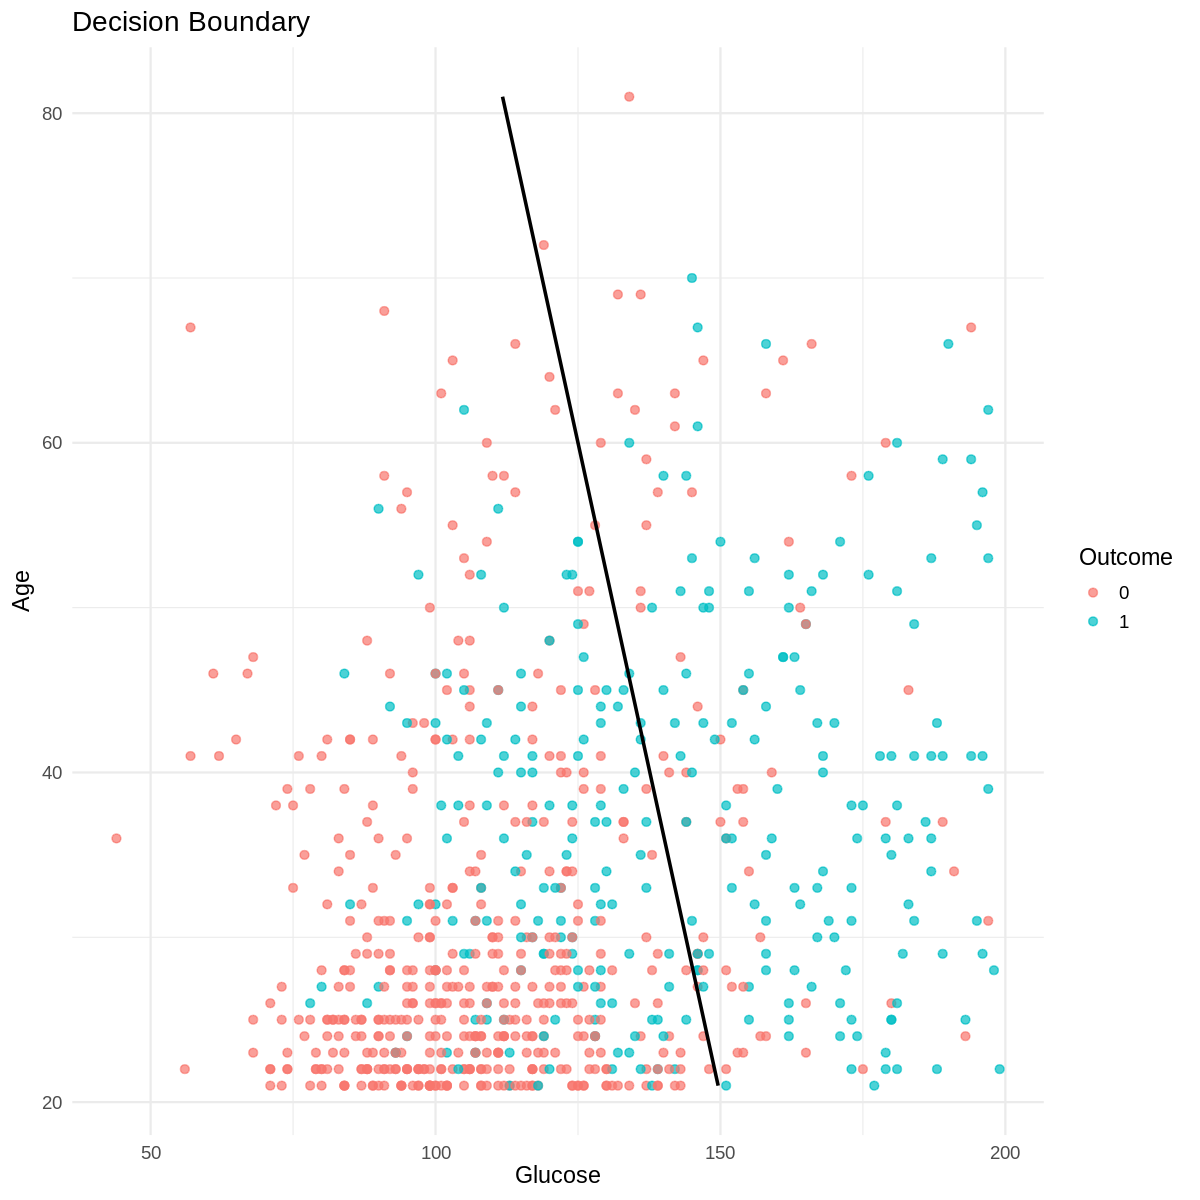

In [27]:
fig <- plot_decision_boundary(lr_model, diabetes_df)
print(fig)

We can see that the model does an OK job separating out those with diabetes from those without. However there are a number of cases that fall on the "wrong" side of the line, which would result in a false positive or false negative prediction.

Question: what is this decision boundry in Logistic Regression?

Answer: The model decision function for 2 variable is: y = w1\*x1 + w2\*x2 + c, which defines a line. The coeficients w1 and w2, and intercept can be extracted using methods using the coef() function on the model fit with glm().

In [28]:
print(coef(lr_model))

(Intercept)     Glucose         Age 
-6.24683731  0.03836154  0.02419374 


## Part 3: Train and Test Sets: Splitting Data

A machine learning model aims to make good predictions on new, previously unseen data. But if you are building a model from your data set, how would you get the previously unseen data? Well, one way is to divide your data set into two subsets:

* **training set** — a subset to train a model.
* **test set** — a subset to test the model.

Good performance on the test set is a useful indicator of good performance on the new data in general, assuming that:

* The test set is large enough.
* You don't cheat by using the same test set over and over.




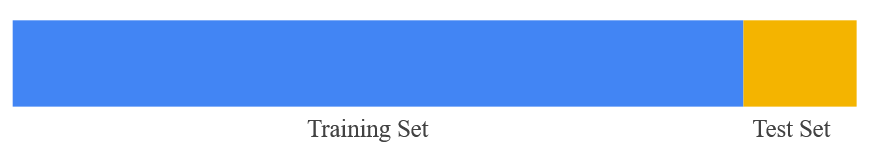

**Never train on test data**. If you are seeing surprisingly good results on your evaluation metrics, it might be a sign that you are accidentally training on the test set. For example, high accuracy might indicate that test data has leaked into the training set

The size of the test set is defined as a percentage of this entire set by the "size" variable of the sample() function. In this case, we split 20% of our dataset into the test set, and will train on the remaining 80% of the data. For reproducibility, we set the seed for the sample() funtion using set.seed().

In [29]:
set.seed(2)

# Create a random sample of row indices for training
train_indices <- sample(1:nrow(diabetes_df), size = 0.8 * nrow(diabetes_df))
#train_index <- createDataPartition(diabetes_df$Outcome, p = 0.8, list = FALSE)

# Split the data into training and testing sets
X_train <- diabetes_df[train_indices, -which(names(diabetes_df) == "Outcome")]
y_train <- diabetes_df[train_indices, "Outcome"]
X_test <- diabetes_df[-train_indices, -which(names(diabetes_df) == "Outcome")]
y_test <- diabetes_df[-train_indices, "Outcome"]


And we can verify the size of our training and test sets using the dim and length methods.

In [30]:
dim(X_train)
dim(X_test)
length(y_train)
length(y_test)

[1] 614   8

[1] 154   8

[1] 614

[1] 154

We can insspect the data using head().

In [31]:
head(X_train)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
710,2,93,64,32,160,38.0,0.674,23
416,3,173,84,33,474,35.7,0.258,22
392,5,166,76,29,125,45.7,0.340,27
273,3,122,78,29,125,23.0,0.254,40
349,3,99,62,19,74,21.8,0.279,26
204,2,99,70,16,44,20.4,0.235,27


In [32]:
head(y_train)

[1] 1 1 1 0 0 0

In [33]:
head(X_test)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7,3,78,50,32,88,31.0,0.248,26
11,4,110,92,29,125,37.6,0.191,30
15,5,166,72,19,175,25.8,0.587,51
16,7,100,72,29,125,30.0,0.484,32
18,7,107,74,29,125,29.6,0.254,31
19,1,103,30,38,83,43.3,0.183,33


In [34]:
head(y_test)

[1] 1 0 1 1 1 0

We can see how many of each class we have using the table() funtion. The training dataset has 614 diabetes patients and the test set has 154.

In [35]:
y_train_counts <- table(y_train)
y_test_counts <- table(y_test)

print("Counts in y_train:")
print(y_train_counts)

print("Counts in y_test:")
print(y_test_counts)

[1] "Counts in y_train:"
y_train
  0   1 
395 219 
[1] "Counts in y_test:"
y_test
  0   1 
105  49 


## Part 4: Train and Test Classification Models

First we train the model using glm() as before, except this time we only use the patient data in the training set.

To make predictions we use the function "predict()" and that takes the trained model as input.

Here, we will train the ML model on all 8 features and not just 2


Fit/train a model on the training dataset by first defining our training data frame, and then calling the glm() function on our training data frame.

In [36]:
#Fit the model
train_data <- data.frame(Outcome = y_train, X_train)
model <- glm(Outcome ~ ., data = train_data, family = binomial)

Every ML classifier outputs a set of numbers for each data point that represents the **probabilty** of classifying that point as a zero (no diabetes) or 1 (diabetes). This data can be found by calling the predict() method on the test set. The method returns an value for each patient in the test set, where the entry is the probability of having diabetes. As we will see below, this is useful when appying different probability thresholds to making a prediction.

In [37]:
y_pred_prob <- predict(model, newdata = X_test, type = "response")
print(y_pred_prob) #probability of 1, or having diabetes only

         7         11         15         16         18         19         24 
0.06404788 0.20071189 0.68467869 0.15998097 0.16614137 0.47756596 0.24671166 
        30         32         33         40         41         47         61 
0.24694613 0.59013293 0.04628293 0.51144030 0.84403158 0.47202419 0.05014259 
        63         64         67         72         73         74         81 
0.01194464 0.32693771 0.14729004 0.39409551 0.80048801 0.25771668 0.10264505 
        82         83         89         98        102        104        106 
0.03009956 0.09901681 0.81916296 0.01416219 0.32454748 0.02742469 0.25217573 
       112        115        117        119        120        121        123 
0.73615550 0.79457953 0.36442869 0.09487691 0.04619976 0.92920781 0.14914368 
       129        132        148        152        156        161        167 
0.20135647 0.63816620 0.24545110 0.11235711 0.90516878 0.42249033 0.49472309 
       172        179        184        185        187        19

We can use the predict() method on the trained model to generate predictions on the test set. The output is actually a probablity, so we also apply a threshold that assigns a value of 1 if the probabily is greater that 0.5, otherwise it assigns a 0.

In [38]:
#Generate Predictions

y_pred_prob <- predict(model, newdata = X_test, type = "response")
y_pred <- ifelse(y_pred_prob > 0.5, 1, 0)
print(y_pred)

  7  11  15  16  18  19  24  30  32  33  40  41  47  61  63  64  67  72  73  74 
  0   0   1   0   0   0   0   0   1   0   1   1   0   0   0   0   0   0   1   0 
 81  82  83  89  98 102 104 106 112 115 117 119 120 121 123 129 132 148 152 156 
  0   0   0   1   0   0   0   0   1   1   0   0   0   1   0   0   1   0   0   1 
161 167 172 179 184 185 187 194 195 201 207 209 211 219 223 224 237 247 249 253 
  0   0   1   1   0   0   1   1   0   0   1   0   0   0   0   1   1   0   0   0 
256 274 277 278 282 294 308 315 316 323 327 332 335 339 340 341 345 352 354 363 
  0   0   0   0   1   1   0   0   0   0   0   0   0   1   1   0   0   0   0   0 
368 370 398 403 409 422 423 424 430 438 441 448 453 455 457 458 467 470 471 476 
  0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0   1   1   0 
483 487 490 493 495 498 509 511 514 529 531 535 538 539 545 551 554 558 571 576 
  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
577 580 591 597 601 634 657 

We can plot the probability of having diabeties as a histogram to visualize the prediction results.

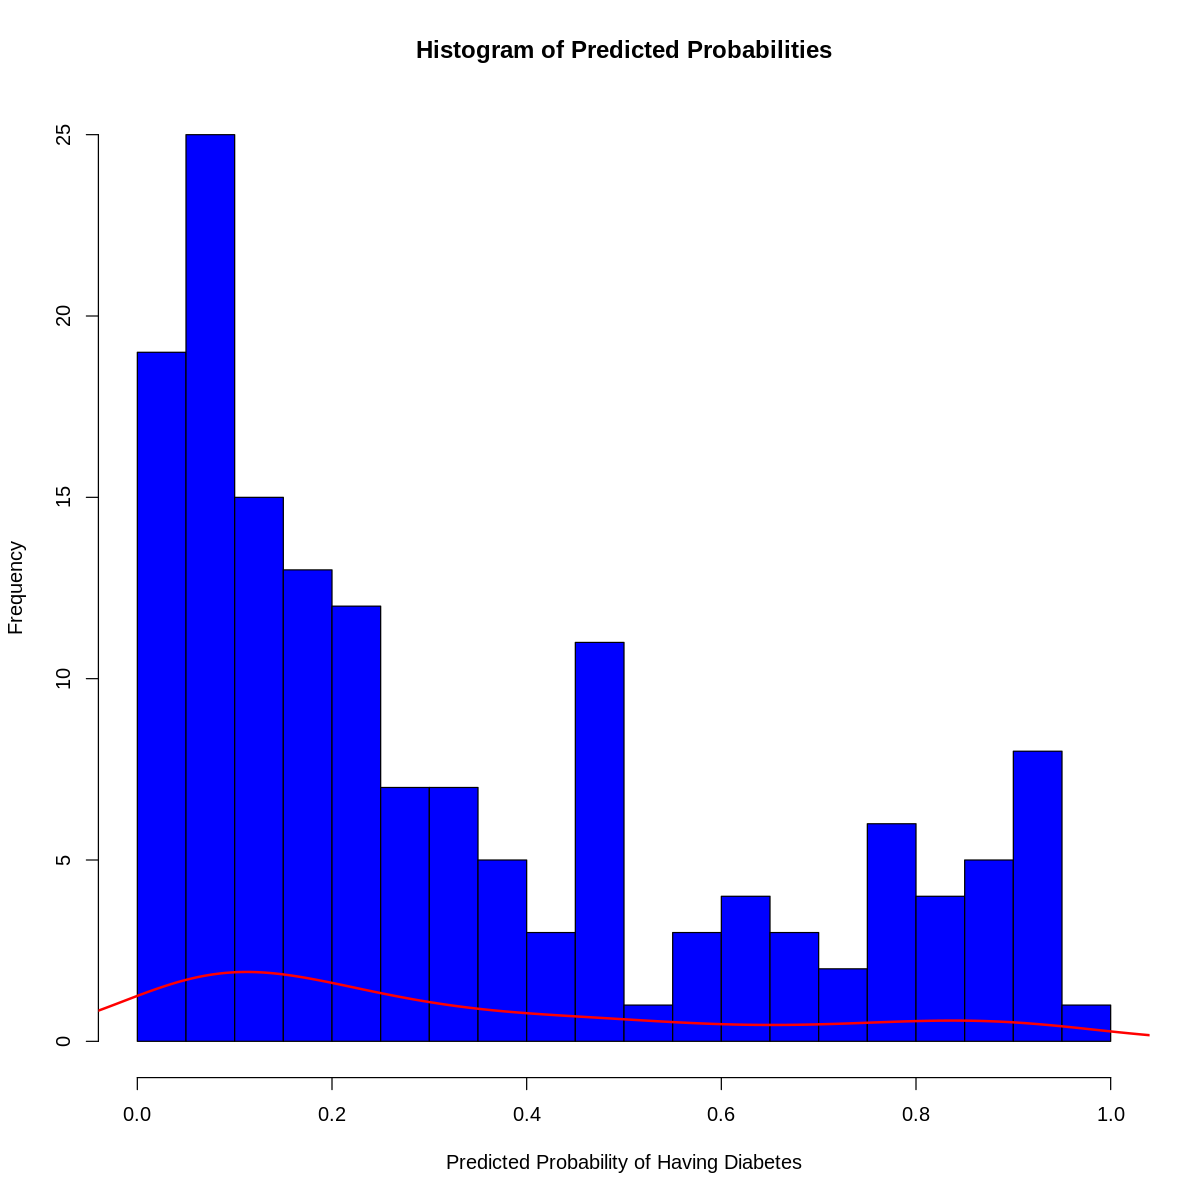

In [39]:
hist(y_pred_prob,
     breaks = 30,
     main = "Histogram of Predicted Probabilities",
     xlab = "Predicted Probability of Having Diabetes",
     col = "blue",
     border = "black")

lines(density(y_pred_prob), col = "red", lwd = 2)

## Part 5: Evaluation of the Classification Model

After training the classification model on the training set and generating predictions on the test set, we would like to quality of the predictions i.e. the performance of the trained classification model on new test set. This is done using standard classification evaluation metrics such as **accuracy, precision and recall**. These require the list of predictions of your model and the actual labels/outcomes (ground truths)

### Confusion Matrix

We calculate the confusion matrix to evaluate performance of our model. We then review and caclulate the different metrics.

A confusion matrix is a cross-tabulation that shows the correct class (or label) for each datapoint that was tested, along with the predicted class. You can use this 2-way table to determine if your model is making Type 1 (False Positve) or Type 2 (False Negative) errors.

In [40]:
cm <- confusionMatrix(as.factor(y_pred), as.factor(y_test), positive = "1")

In [41]:
cm

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 96 21
         1  9 28
                                          
               Accuracy : 0.8052          
                 95% CI : (0.7337, 0.8645)
    No Information Rate : 0.6818          
    P-Value [Acc > NIR] : 0.0004369       
                                          
                  Kappa : 0.5197          
                                          
 Mcnemar's Test P-Value : 0.0446097       
                                          
            Sensitivity : 0.5714          
            Specificity : 0.9143          
         Pos Pred Value : 0.7568          
         Neg Pred Value : 0.8205          
             Prevalence : 0.3182          
         Detection Rate : 0.1818          
   Detection Prevalence : 0.2403          
      Balanced Accuracy : 0.7429          
                                          
       'Positive' Class : 1               
                                    

A confusion matriz is a way to visualize how many predictions were correct. That is, the predicted diagnosis on the test set matched the prediction. We can see that 96 patients were correctly predicted to not have diabetes and 28 patients were correctly predicted to have diabetes. However, there were 9 patients where the model predicted them to have diabetes when they did not, and 21 patients that had diabetes were incorrecly diagnosed as being health. We also need the library reshape2 to access functions for manipulating our data. "reshape2" was previously installed as a dependency of the "caret" library.

Using Prediction, Reference as id variables



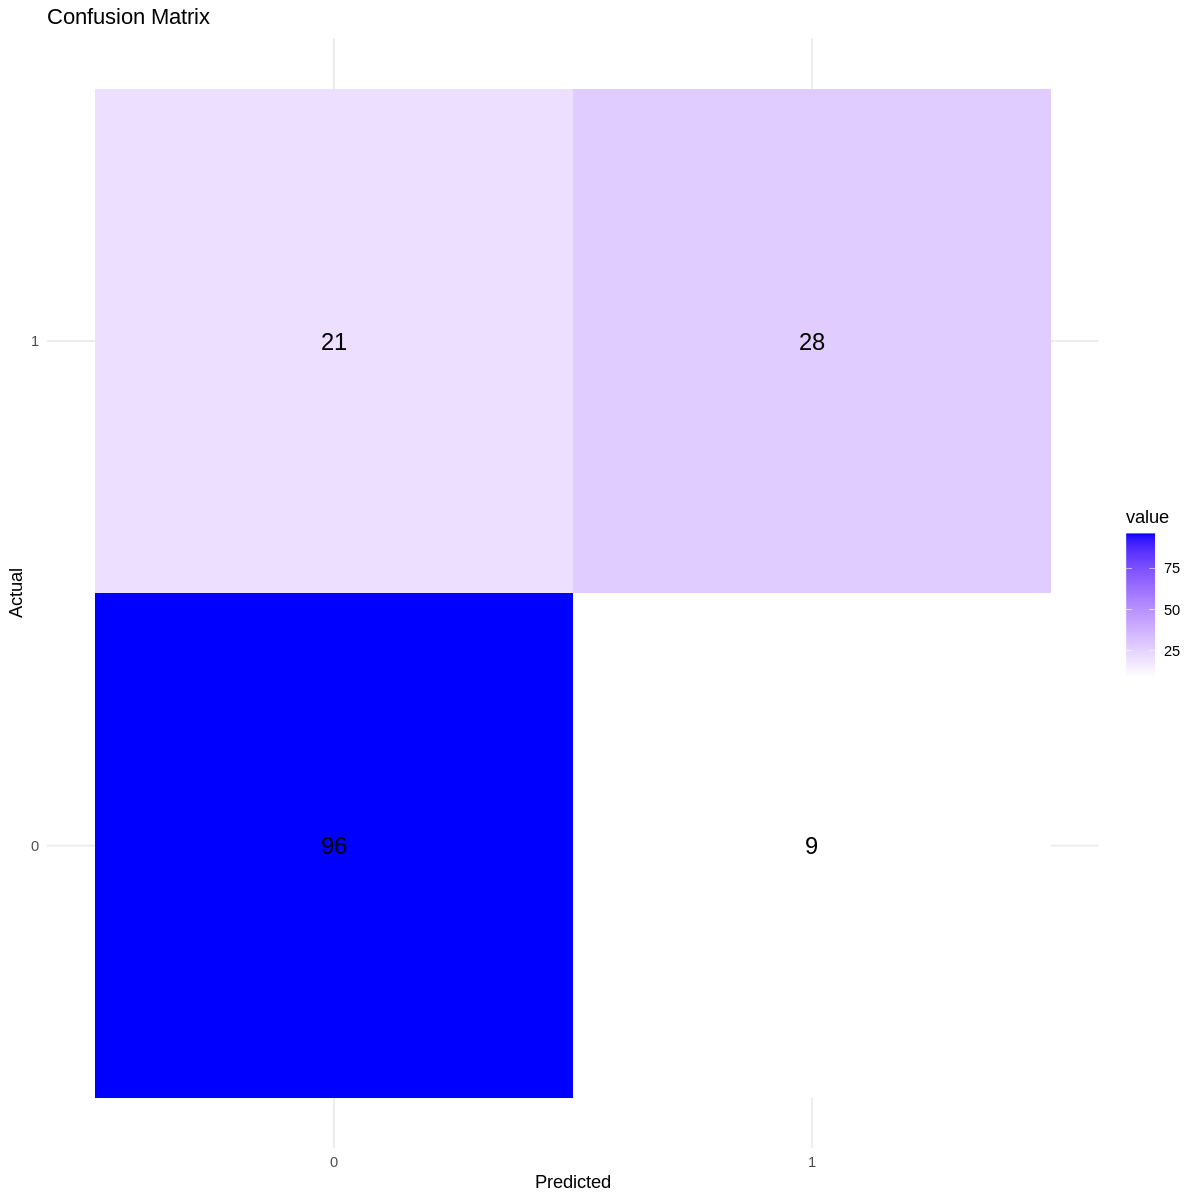

In [42]:
library(reshape2)
cm_table <- as.data.frame(cm$table)


# Convert the table for ggplot2
cm_melted <- melt(cm_table)

# Plot the confusion matrix with ggplot2
ggplot(data = cm_melted, aes(x = Prediction, y = Reference, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Confusion Matrix", x = "Predicted", y = "Actual") +
  theme_minimal()

### Types of Errors

When making a prediction for a two-class classification problem, the following types of prediction vs actual can be made by a classifier:

* **False Positive (FP):** predict an event when there was no event.
* **False Negative (FN):** predict no event when in fact there was an event.
* **True Positive (TP):** predict an event when there was an event.
* **True Negative (TN):** predict no event when in fact there was no event.

Remember

* Type I Error  = False Positive  (Predicted 1, Actual 0)
* Type II Error = False Negative: (Predicted 0, Actual 1)

In [43]:
cm_table <- cm$table
#We use the confusion matrix function to extract the different types of errors
tn <- cm_table[1, 1]  # True negatives
fp <- cm_table[2, 1]  # False positives
fn <- cm_table[1, 2]  # False negatives
tp <- cm_table[2, 2]  # True positives

# Print TN, FP, FN, TP
tn
fp
fn
tp

[1] 96

[1] 9

[1] 21

[1] 28

### Compute different evaluation metrics

We can quantify error in different ways to get a sense of how well the model is performing. In this section we will use scoring functions and the types of errors derived from the confusion matrix functions to evaluate our classification model.

In [44]:
# Accuracy
accuracy <- (tp + tn) / (tp + tn + fp + fn)
cat('Accuracy: ', sprintf('%.3f', accuracy), "\n")

# Recall/Sensitivity/True Positive Rate (TPR)
recall <- tp / (tp + fn)
cat('Recall: ', sprintf('%.3f', recall), "\n")

# Precision
precision <- tp / (tp + fp)
cat('Precision: ', sprintf('%.3f', precision), "\n")

# Specificity/True Negative Rate (TNR)
specificity <- tn / (tn + fp)
cat('Specificity: ', sprintf('%.3f', specificity), "\n")

# F1 Score
f1 <- 2 * (precision * recall) / (precision + recall)
cat('F1 Score: ', sprintf('%.3f', f1), "\n")

Accuracy:  0.805 
Recall:  0.571 
Precision:  0.757 
Specificity:  0.914 
F1 Score:  0.651 


These functions are also a part of the "Metrics" package.

In [45]:
#install.packages("Metrics")
library(Metrics)


Attaching package: ‘Metrics’


The following objects are masked from ‘package:caret’:

    precision, recall




In [46]:
# Accuracy
accuracy <- sum(y_pred == y_test) / length(y_test)
cat('Accuracy: ', sprintf('%.3f', accuracy), "\n")

# Recall
recall <- recall((y_test), (y_pred))
cat('Recall: ', sprintf('%.3f', recall), "\n")

# Precision
precision <- posPredValue(as.factor(y_pred), as.factor(y_test), positive="1")
cat('Precision: ', sprintf('%.3f', precision), "\n")

# F1 Score
f1 <- 2 * (precision * recall) / (precision + recall)
cat('F1 Score: ', sprintf('%.3f', f1), "\n")

Accuracy:  0.805 
Recall:  0.571 
Precision:  0.757 
F1 Score:  0.651 


Helper function that take actual labels and predictions as input and prints the classification metrics. Same as before just encapsulated in a function so that we can call it with different inputs

In [47]:
#Function that calculates and print metrics
show_metrics <- function(y_test, y_pred) {
  cat('====================\n')

  # Accuracy
  accuracy <- sum(y_pred == y_test) / length(y_test)
cat('Accuracy: ', sprintf('%.3f', accuracy), "\n")

# Recall
recall <- recall((y_test), (y_pred))
cat('Recall: ', sprintf('%.3f', recall), "\n")

# Precision
precision <- posPredValue(as.factor(y_pred), as.factor(y_test), positive="1")
cat('Precision: ', sprintf('%.3f', precision), "\n")

# F1 Score
f1 <- 2 * (precision * recall) / (precision + recall)
cat('F1 Score: ', sprintf('%.3f', f1), "\n")

  cat('====================\n')
}


In [48]:
show_metrics(y_test, y_pred)

Accuracy:  0.805 
Recall:  0.571 
Precision:  0.757 
F1 Score:  0.651 


**Metrics with different threshold**

We can use the prediction probablility to alter the threshold where a predicion is made. Initially, we can use a threshold of 50% (threshold=0.5) to predict a diabetes diagnosis when the prediction probability is greater than 50%.

In [49]:
#Function that returns predictions at a specific threshold
get_predictions <- function(y_pred_prob, threshold = 0.5) {
  if (is.vector(y_pred_prob)) {
    # If it's a vector, return predictions based on threshold for a binary classification
    predictions <- ifelse(y_pred_prob <= threshold, 0, 1)
  } else {
    # If it's a matrix, assume second column contains probabilities for class 1
    predictions <- ifelse(y_pred_prob[, 2] <= threshold, 0, 1)
  }
  return(predictions)
}

**Increase the threshold**

We can be more strict, and apply a higher prediction threshold. When we increase the threshold to 70% there is a change in the model performance. The number of false positives decreases, but false negatives increase. As a result, precision increases, while recall decreases:

In [50]:
y_pred1 <- get_predictions(y_pred_prob, 0.7)
show_metrics(y_test, y_pred1)

Accuracy:  0.773 
Recall:  0.408 
Precision:  0.769 
F1 Score:  0.533 


**Decrease the threshold**
Similarly, a decrease in the threshold also changes the performance. False positives increase, and false negatives decrease. As a result, this time, precision decreases and recall increases:


In [51]:
y_pred2 = get_predictions(y_pred_prob, 0.3)
show_metrics(y_test, y_pred2)

Accuracy:  0.714 
Recall:  0.694 
Precision:  0.540 
F1 Score:  0.607 


#### Threshold independent Metric: **AUC-ROC**

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate


An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

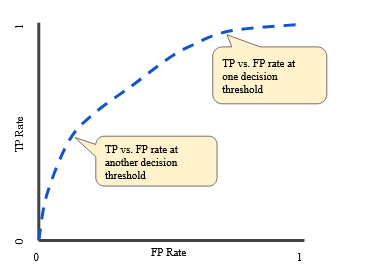

The library "pROC" has several functions that let us quantify the ROC. First we need to install and load the library.

In [52]:
#install.packages("pROC")
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following object is masked from ‘package:Metrics’:

    auc


The following objects are masked from ‘package:stats’:

    cov, smooth, var




And now we can calculate the AUC-ROC.

In [53]:
#AUROC = Area Under the Receiver Operating Characteristic curve

if (is.vector(y_pred_prob)) {
  prob_class_1 <- y_pred_prob
} else {
  prob_class_1 <- y_pred_prob[, 2]  # Assuming class 1 probabilities are in the second column
}

# Calculate AUC-ROC
roc_obj <- roc(y_test, prob_class_1)
roc_auc <- roc_obj$auc

# Print the AUC-ROC value
cat('AUCROC: ', sprintf('%.3f', roc_auc), "\n")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUCROC:  0.814 


Generate FPR and TPR at different thresholds using the results of the roc() function.

In [54]:
fpr <- 1 - roc_obj$specificities  # False Positive Rate
tpr <- roc_obj$sensitivities        # True Positive Rate
thresholds <- roc_obj$thresholds    # Thresholds

In [55]:
# Check shape of y_test
y_test_shape <- length(y_test)  # For a vector
cat("Shape of y_test:", y_test_shape, "\n")

# Check shape of thresholds
thresholds_shape <- length(thresholds)  # For a vector
cat("Shape of thresholds:", thresholds_shape, "\n")

Shape of y_test: 154 
Shape of thresholds: 155 


DataFrame showing three columns: FPR, TPR and Threshold. This represents different values of FPR and TPR at different thresholds

In [56]:
roc_df <- data.frame(FPR = fpr, TPR = tpr, Thresholds = thresholds)
roc_df

FPR,TPR,Thresholds
<dbl>,<dbl>,<dbl>
1.0000000,1.0000000,-Inf
0.9904762,1.0000000,0.01305342
0.9809524,1.0000000,0.01530063
0.9714286,1.0000000,0.02193188
0.9619048,1.0000000,0.02822972
0.9523810,1.0000000,0.02927741
0.9428571,1.0000000,0.02980981
0.9333333,1.0000000,0.03012302
0.9238095,1.0000000,0.03041179


In [57]:
#Function to plot ROC curve
plot_roc <- function(y_test, predictions, title) {
    # Calculate ROC curve
    roc_obj <- roc(y_test, predictions)

    # Calculate AUC
    roc_auc <- roc_obj$auc
    cat('AUROC: ', sprintf('%.3f', roc_auc), "\n")

    # Plot ROC curve
    plot(roc_obj, main=title, col="blue", lwd=2)
    abline(a=0, b=1, lty=2, col="red")  # Diagonal line
    legend("bottomright", legend=paste("ROC curve (area =", sprintf('%.2f', roc_auc), ")"),
           col="blue", lwd=2)
}

Let's plot the ROC curves for a perfect classifier, classifier based on random guessing and our trained model : Logistic regression. The area under the ROC curve is the AUC-ROC metric. A perfect classifier has AUCROC = 1 and random guessing will have a AUCROC around 0.5.
Our trained Logistic Regression classifier has a AUCROC of 0.8

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUROC:  1.000 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUROC:  0.470 


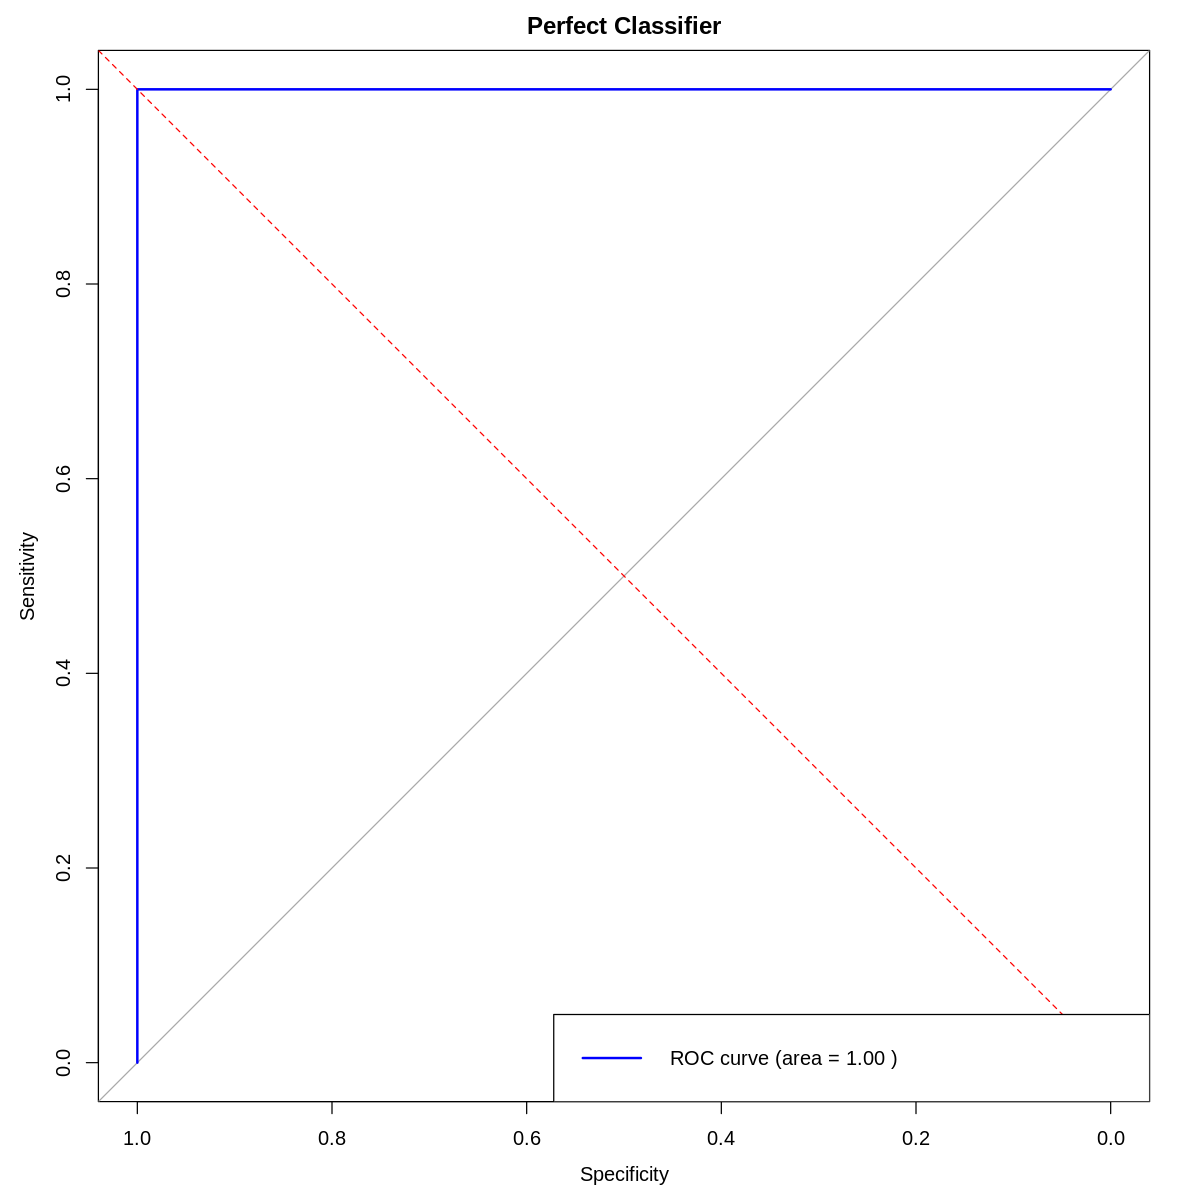

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUROC:  0.814 


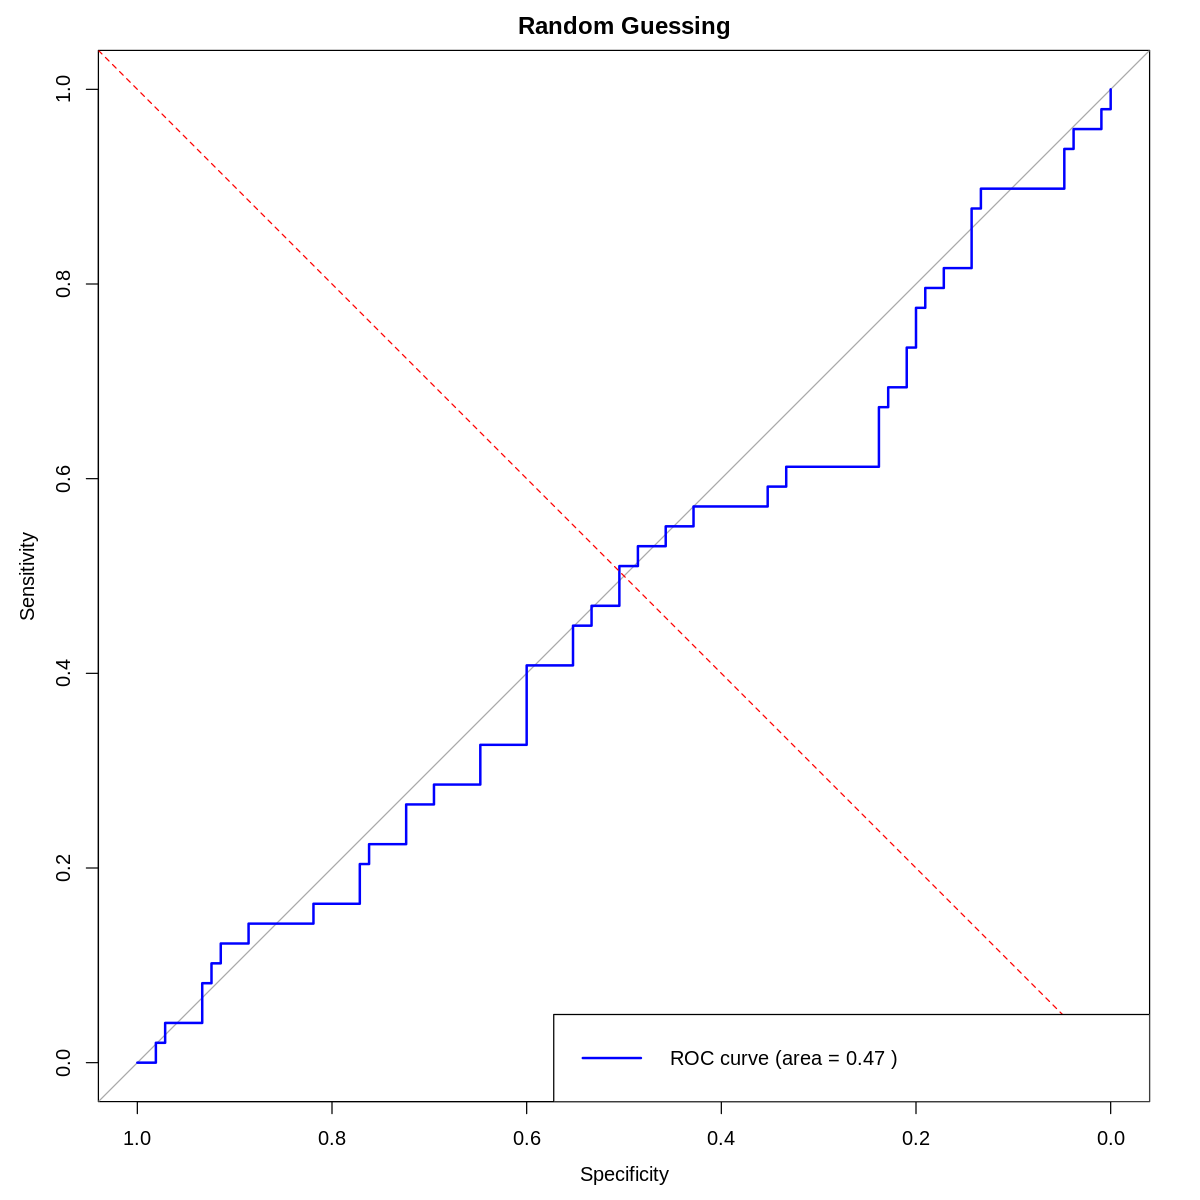

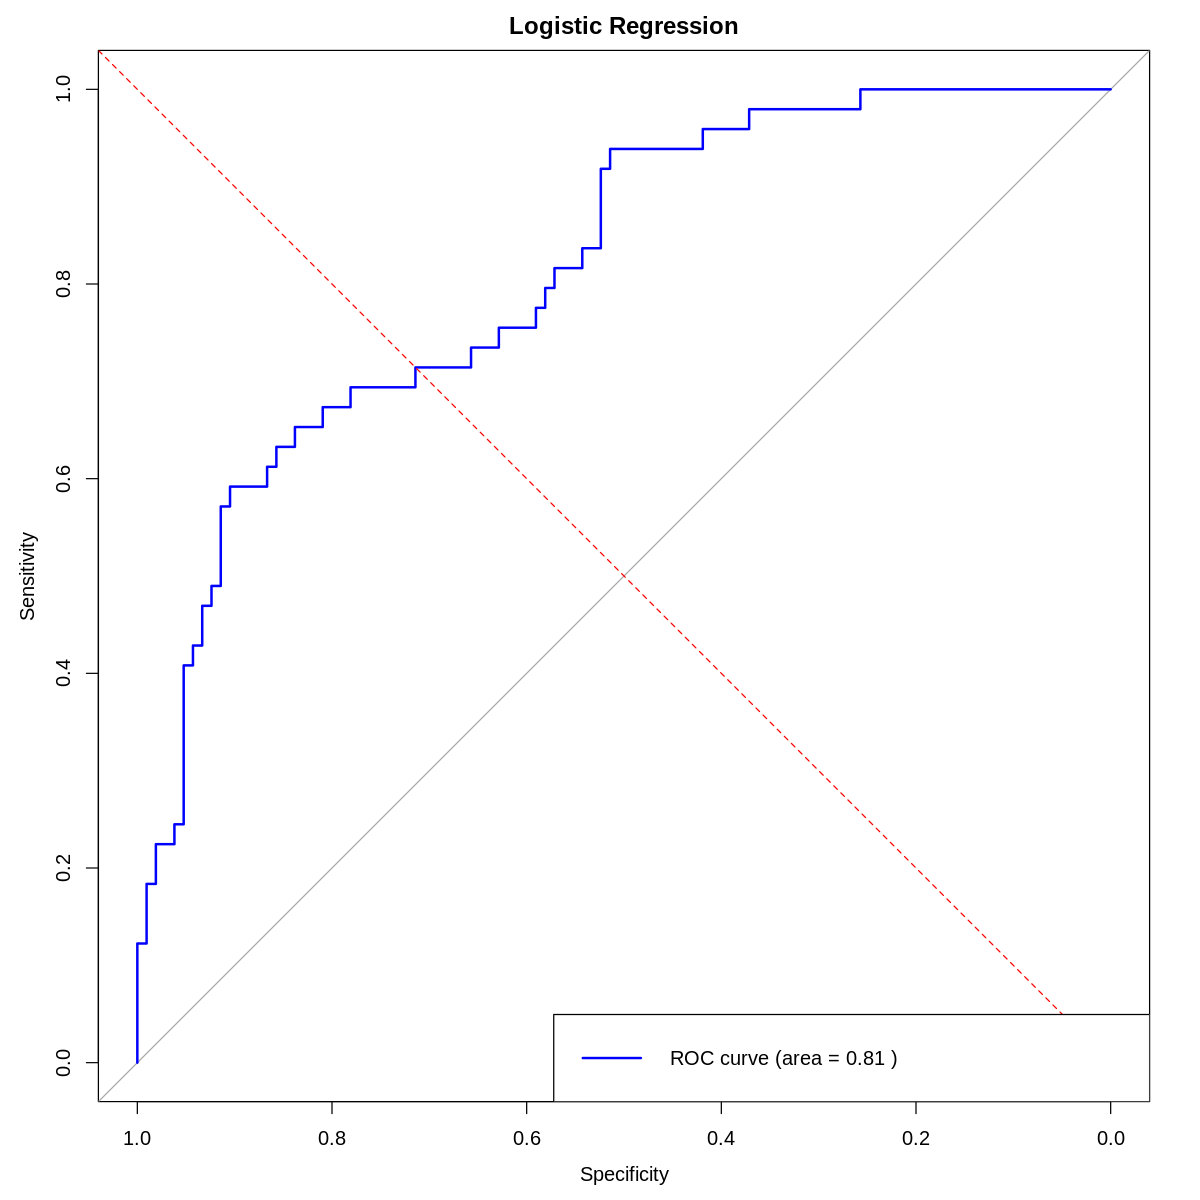

In [58]:
# Perfect classifier
perfect_predictions <- y_test  # Perfect predictions (1 for positive class and 0 for negative)
plot_roc(y_test, perfect_predictions, "Perfect Classifier")

# Random guessing
random_predictions <- runif(length(y_test))  # Random predictions between 0 and 1
plot_roc(y_test, random_predictions, "Random Guessing")

# Logistic Regression predictions
logistic_predictions <- y_pred_prob  # Assuming class 1 probabilities are in the second column
plot_roc(y_test, logistic_predictions, "Logistic Regression")

### Classification Report

You can also generate the precision, recall, and f1 scores using classification_report.

* Scores of every class correspond to the accuracy of the classifier in classifying that particular class compared to the other class.

* The support is the number of samples of the true response that are in that class.

* The last line gives a weighted average of precision, recall and f1-score where the weights are the support values.

In [59]:
confusion_matrix <- confusionMatrix(as.factor(y_pred), as.factor(y_test))

# Print the confusion matrix
print(confusion_matrix)

# Print additional metrics
cat("\nAccuracy: ", confusion_matrix$overall['Accuracy'], "\n")
cat("Precision: ", confusion_matrix$byClass['Precision'], "\n")
cat("Recall: ", confusion_matrix$byClass['Recall'], "\n")
cat("F1 Score: ", confusion_matrix$byClass['F1'], "\n")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 96 21
         1  9 28
                                          
               Accuracy : 0.8052          
                 95% CI : (0.7337, 0.8645)
    No Information Rate : 0.6818          
    P-Value [Acc > NIR] : 0.0004369       
                                          
                  Kappa : 0.5197          
                                          
 Mcnemar's Test P-Value : 0.0446097       
                                          
            Sensitivity : 0.9143          
            Specificity : 0.5714          
         Pos Pred Value : 0.8205          
         Neg Pred Value : 0.7568          
             Prevalence : 0.6818          
         Detection Rate : 0.6234          
   Detection Prevalence : 0.7597          
      Balanced Accuracy : 0.7429          
                                          
       'Positive' Class : 0               
                                    

Another R package for generating these performacne statistics is "yardstick".

In [60]:
#install.packages('yardstick')
library(yardstick)


Attaching package: ‘yardstick’


The following objects are masked from ‘package:Metrics’:

    accuracy, mae, mape, mase, precision, recall, rmse, smape


The following objects are masked from ‘package:caret’:

    precision, recall, sensitivity, specificity




In [61]:


# Create a tibble for predictions
results <- data.frame(
    truth = as.factor(y_test),
    estimate = as.factor(y_pred)
)

# Calculate metrics
metrics <- results %>%
    metrics(truth = truth, estimate = estimate)

# Print metrics
print(metrics)

# A tibble: 2 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.805
2 kap      binary         0.520


### Trying Other classifiers

In [62]:
#install.packages("randomForest")
library(randomForest)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




Let's try some other classifiers. We will build a Random Forest classifier using the randomForest() function much like we did before.

https://www.rdocumentation.org/packages/randomForest/versions/4.7-1.2/topics/randomForest

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 90 21
         1 15 28
                                          
               Accuracy : 0.7662          
                 95% CI : (0.6914, 0.8306)
    No Information Rate : 0.6818          
    P-Value [Acc > NIR] : 0.01359         
                                          
                  Kappa : 0.443           
                                          
 Mcnemar's Test P-Value : 0.40466         
                                          
            Sensitivity : 0.8571          
            Specificity : 0.5714          
         Pos Pred Value : 0.8108          
         Neg Pred Value : 0.6512          
             Prevalence : 0.6818          
         Detection Rate : 0.5844          
   Detection Prevalence : 0.7208          
      Balanced Accuracy : 0.7143          
                                          
       'Positive' Class : 0               
                                    

Using Prediction, Reference as id variables




Accuracy:  0.7662338 
Precision:  0.8108108 
Recall:  0.8571429 
F1 Score:  0.8333333 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUCROC:  0.835762876579203"


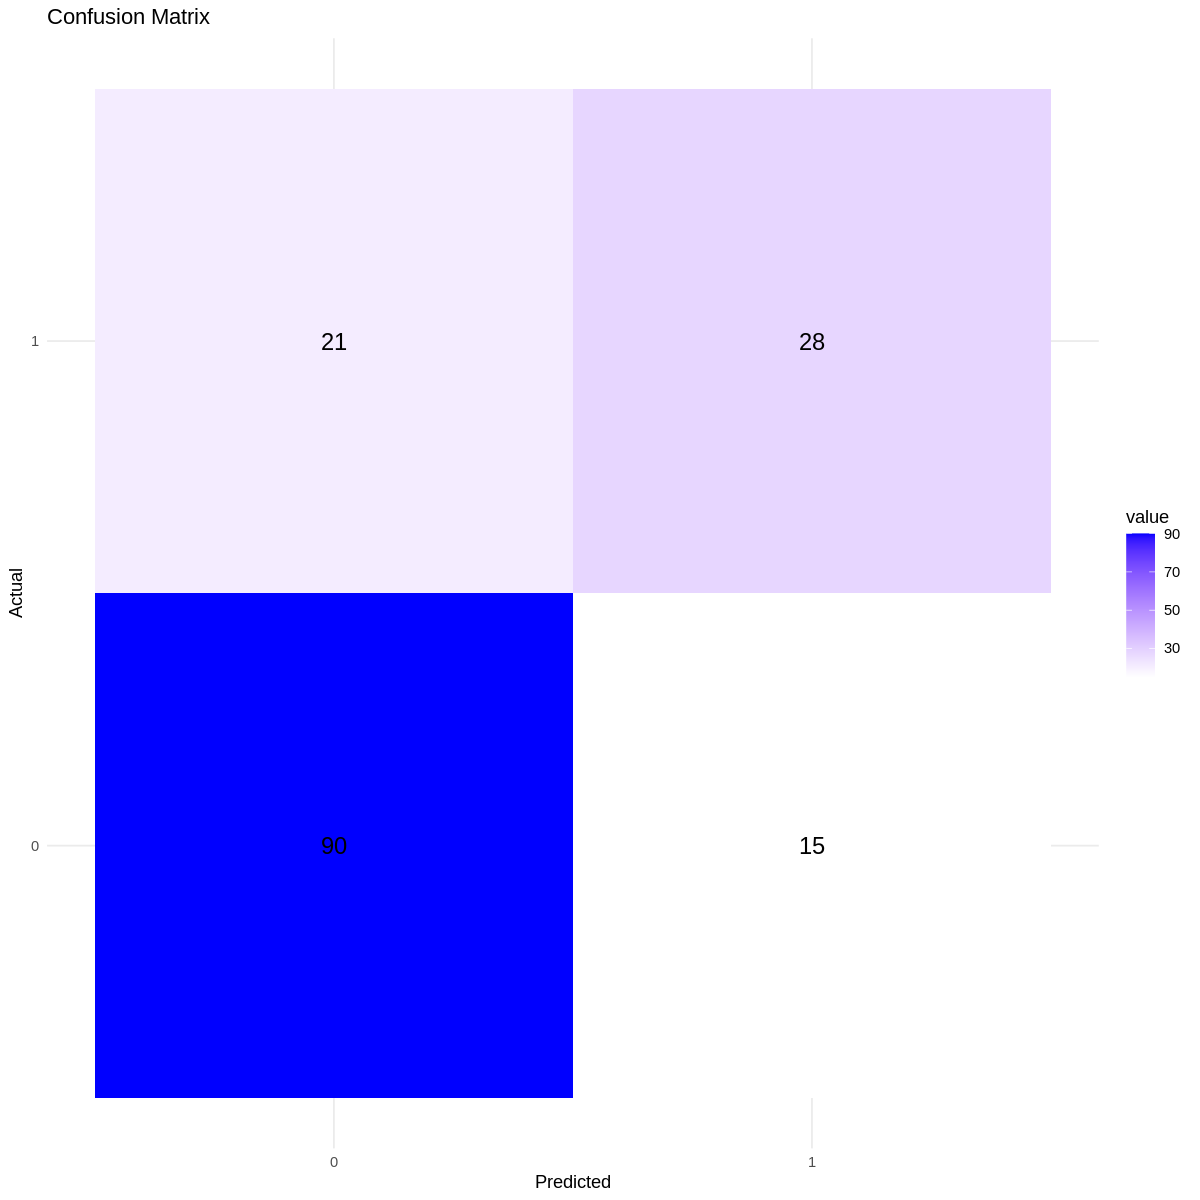

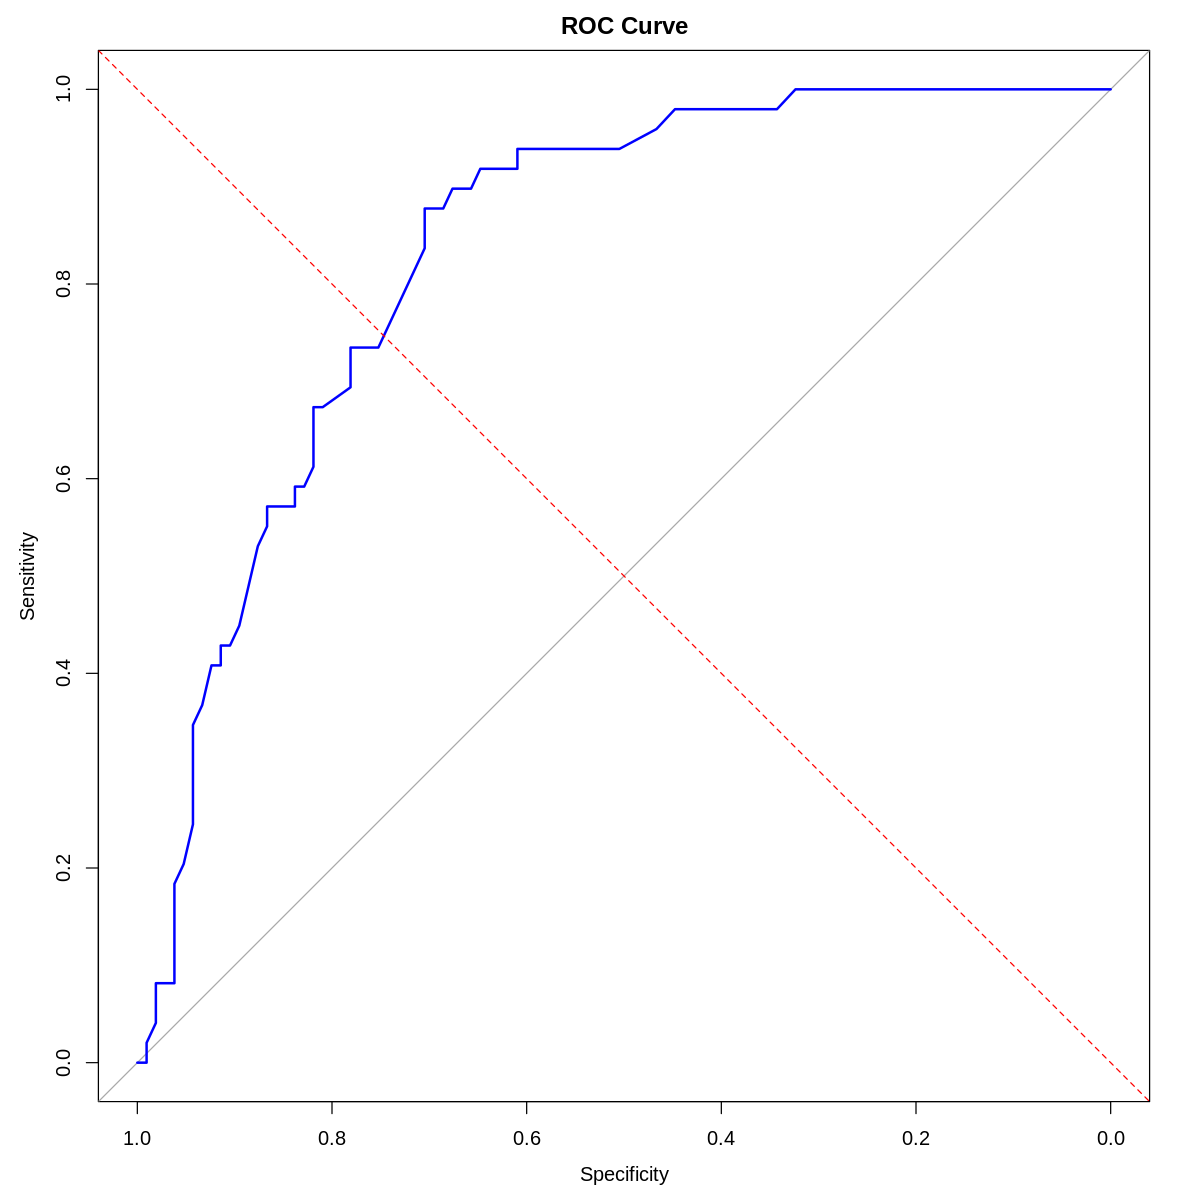

In [63]:
# Ensure the target variable is a factor

y_train <- as.factor(y_train)
y_test <- as.factor(y_test)

# Fit the Random Forest model
model <- randomForest(y_train ~ ., data = X_train, ntree = 100)

# Prediction probabilities and classes
predictions_proba <- predict(model, X_test, type = "prob")
predictions <- predict(model, X_test)

cm <- confusionMatrix(as.factor(predictions), as.factor(y_test))
print(cm)  # Display the confusion matrix

# Plot confusion matrix using caret's confusion matrix visualization
cm_table <- as.data.frame(cm$table)
cm_melted <- melt(cm_table)

# Plot the confusion matrix with ggplot2
ggplot(data = cm_melted, aes(x = Prediction, y = Reference, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Confusion Matrix", x = "Predicted", y = "Actual") +
  theme_minimal()


# Print classification metrics
cat("\nAccuracy: ", cm$overall['Accuracy'], "\n")
cat("Precision: ", cm$byClass['Precision'], "\n")
cat("Recall: ", cm$byClass['Recall'], "\n")
cat("F1 Score: ", cm$byClass['F1'], "\n")

# Compute and print AUC-ROC
roc_auc <- roc(y_test, predictions_proba[, 2])  # Assuming class 1 probabilities are in the second column
print(paste('AUCROC: ', (roc_auc)$auc))

# Plot ROC curve
plot(roc_auc, main = "ROC Curve", col = "blue", lwd = 2)
abline(a=0, b=1, lty=2, col="red")  # Diagonal line for random guessing

## Part 6: Feature Importance using Tree-Based Classifiers

We will use a tree based ensemble classifier: **XGBoost**, which is very a popular ML model to output feature importance. A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

XGGBoost Documentation: https://xgboost.readthedocs.io/en/latest/
Check this article for more information on feature importance usinfg XGBoost: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/



In [64]:
#install.packages("xgboost")
library(xgboost)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [65]:
# Prepare the training data
X_train_matrix <- as.matrix(X_train)  # Convert feature data to a matrix
y_train_numeric <- as.numeric(as.factor(y_train)) - 1  # Convert target to numeric

# Create DMatrix for XGBoost
dtrain <- xgb.DMatrix(data = X_train_matrix, label = y_train_numeric)

# Fit the XGBoost model
model <- xgboost(data = dtrain,
                 nrounds = 100,  # Number of boosting iterations
                 max_depth = 3,  # Maximum depth of trees
                 eta = 0.3,      # Learning rate
                 objective = "binary:logistic",  # Binary classification
                 verbose = 1)    # Verbosity of output

[1]	train-logloss:0.592999 
[2]	train-logloss:0.534422 
[3]	train-logloss:0.494133 
[4]	train-logloss:0.468829 
[5]	train-logloss:0.449840 
[6]	train-logloss:0.433751 
[7]	train-logloss:0.417024 
[8]	train-logloss:0.405804 
[9]	train-logloss:0.394202 
[10]	train-logloss:0.385534 
[11]	train-logloss:0.379299 
[12]	train-logloss:0.372022 
[13]	train-logloss:0.366129 
[14]	train-logloss:0.359340 
[15]	train-logloss:0.352384 
[16]	train-logloss:0.348462 
[17]	train-logloss:0.345815 
[18]	train-logloss:0.341729 
[19]	train-logloss:0.337103 
[20]	train-logloss:0.328706 
[21]	train-logloss:0.323746 
[22]	train-logloss:0.319991 
[23]	train-logloss:0.317995 
[24]	train-logloss:0.311836 
[25]	train-logloss:0.310162 
[26]	train-logloss:0.308253 
[27]	train-logloss:0.306374 
[28]	train-logloss:0.303068 
[29]	train-logloss:0.299966 
[30]	train-logloss:0.296626 
[31]	train-logloss:0.294310 
[32]	train-logloss:0.291247 
[33]	train-logloss:0.287283 
[34]	train-logloss:0.282711 
[35]	train-logloss:0.28

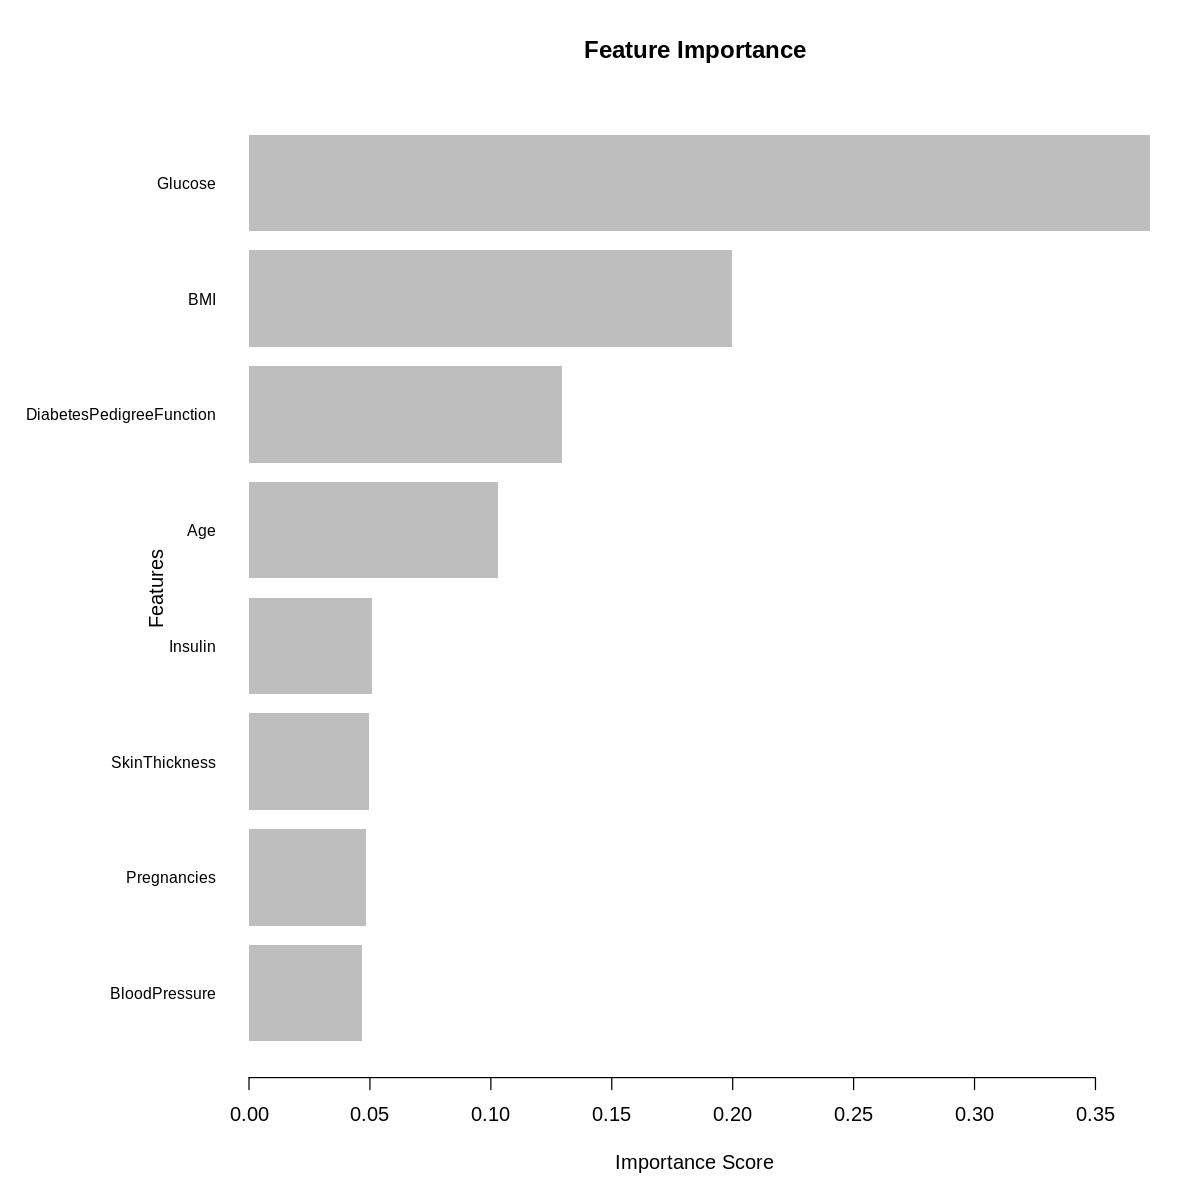

In [66]:
# plot feature importance
importance_matrix <- xgb.importance(feature_names = colnames(X_train), model = model)

# Plot feature importance
xgb.plot.importance(importance_matrix,
                     main = "Feature Importance",
                     xlab = "Importance Score",
                     ylab = "Features")

The results should indicate that Body Mass or a family history of Diabeties or Glucose levels contribute the most the prediction of Diabeties in this model.

 **Note:** Due to the to small size of this example data set and the randomization used making a training and test set the order of improtance could very in different runs.

Larger sets are needed for reproducible machine learning.

# **Credits**

**The END** <br>
**Authors: Dr. Samir Gupta, Dr. Matthew McCoy, Jia Li Dong (M.S.) & ICBI AIM-AHEAD Team**

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/HIDSLOGO.AA1.jpg" alt="Powered by" width="500"/>

